In [1]:
!nvidia-smi

Sun Apr 17 13:48:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   54C    P2    49W / 240W |    501MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import gdown
gdown.download("https://drive.google.com/uc?export=download&confirm=pbef&id=1-LFFkFKNuyBO1sjkM4t_AArIXr3JAOyl")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-LFFkFKNuyBO1sjkM4t_AArIXr3JAOyl
To: /root/GPEN/data1024x1024.zip
100%|██████████| 2.74G/2.74G [04:37<00:00, 9.87MB/s]


'data1024x1024.zip'

In [ ]:
!unzip /root/GPEN/data1024x1024.zip

In [ ]:
# clone the repository
%cd /content
!rm -rf GPEN
!git clone https://github.com/yangxy/GPEN.git
%cd GPEN

/content
Cloning into 'GPEN'...
remote: Enumerating objects: 591, done.
remote: Counting objects: 100% (591/591), done.
remote: Compressing objects: 100% (499/499), done.
remote: Total 591 (delta 155), reused 507 (delta 76), pack-reused 0
Receiving objects: 100% (591/591), 124.48 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/content/GPEN


In [ ]:
%cd GPEN

/content/GPEN


In [4]:
# set up the environment 
!pip install -r requirements.txt
!pip install piq

In [2]:
!wget "https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/GPEN-BFR-512.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116208&Signature=hBgvVvKVSNGeXqT8glG%2Bd2t2OKc%3D" -O weights/GPEN-BFR-512.pth

--2022-04-17 01:56:13--  https://public-vigen-video.oss-cn-shanghai.aliyuncs.com/robin/models/GPEN-BFR-512.pth?OSSAccessKeyId=LTAI4G6bfnyW4TA4wFUXTYBe&Expires=1961116208&Signature=hBgvVvKVSNGeXqT8glG%2Bd2t2OKc%3D
Resolving public-vigen-video.oss-cn-shanghai.aliyuncs.com (public-vigen-video.oss-cn-shanghai.aliyuncs.com)... 47.101.88.25
Connecting to public-vigen-video.oss-cn-shanghai.aliyuncs.com (public-vigen-video.oss-cn-shanghai.aliyuncs.com)|47.101.88.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284085738 (271M) [application/octet-stream]
Saving to: ‘weights/GPEN-BFR-512.pth’

weights/GPEN-BFR-51 100%[===================>] 270.92M  2.09MB/s    in 3m 22s  

2022-04-17 01:59:39 (1.34 MB/s) - ‘weights/GPEN-BFR-512.pth’ saved [284085738/284085738]



In [1]:
import math
import random
import os
import cv2
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import __init_paths
import torch
from torch import nn, autograd, optim
from torch.nn import functional as F
from torch.utils import data
import torch.distributed as dist
from torchvision import transforms, utils

from training.data_loader.dataset_face import FaceDataset
from face_model.gpen_model import FullGenerator
from piq import psnr
from training import lpips
import itertools

plt.rcParams["figure.figsize"] = (7,7)

In [2]:
generator = FullGenerator(512, 512, 8, channel_multiplier=2, narrow=1, device="cuda").to("cuda")

In [3]:
ckpt = torch.load("weights/GPEN-BFR-512.pth")
generator.load_state_dict(ckpt)

<All keys matched successfully>

In [4]:
BATCH = 8
NUM_SKIP = 0
ITER = int(29999/BATCH) + 1

def sample_data(loader):
    while True:
        for batch in loader:
            yield batch

dataset = FaceDataset("data1024x1024", 512)
dataset.HQ_imgs = sorted(dataset.HQ_imgs)[NUM_SKIP * BATCH:]
loader = data.DataLoader(
        dataset,
        batch_size=BATCH,
    )
loader = sample_data(loader)

In [ ]:
import os
dir = os.listdir("/content/drive/MyDrive/Colab/GPEN_hq_512/")

In [5]:
def tensor2img(img, pmax=255.0, imtype=np.uint8):
    img_t = img * 0.5 + 0.5
    img_t = img_t.squeeze(0).permute(1, 2, 0).flip(2) # RGB->BGR
    img_np = np.clip(img_t.float().cpu().numpy(), 0, 1) * pmax

    return img_np.astype(imtype)

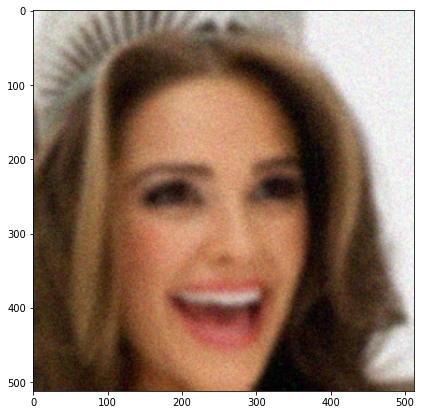

In [6]:
plt.imshow(tensor2img(dataset[0][0])[:,:,::-1])

In [32]:
torch.cuda.empty_cache()

In [ ]:
psnr_list = torch.load("/content/drive/MyDrive/psnr.pt")
psnr_list.shape

In [31]:
del psnr_list

In [30]:
del generator

In [28]:
sys.getrefcount(id(out_data))

NameError: name 'out_data' is not defined

In [25]:
id(out_data)

140305580619072

In [5]:
generator.eval()
psnr_list = torch.tensor([], device="cuda")
EPS = 1e-8

for itr in range(NUM_SKIP, ITER):
    degraded_img, real_img = next(loader)
    degraded_img = degraded_img.to("cuda")
    real_img = real_img.to("cuda")

    with torch.no_grad():
        out_data, _ = generator(degraded_img)
    torch.cuda.empty_cache()
    
    out_data = torch.clamp(out_data * 0.5 + 0.5, 0, 1)
    real_img = torch.clamp(real_img * 0.5 + 0.5, 0, 1)
    mse = torch.mean((real_img - out_data) ** 2, dim=[1, 2, 3])
    res = 10 * torch.log10(1./(mse + EPS))

    psnr_list = torch.cat((psnr_list, res), 0)
    if (itr % 8 == 7):
        print(itr * BATCH + BATCH, torch.mean(psnr_list))
    if (itr % 64 == 63):
        torch.save(psnr_list, "psnr.pt")

64 tensor(24.7304, device='cuda:0')
128 tensor(24.7676, device='cuda:0')
192 tensor(24.6754, device='cuda:0')


KeyboardInterrupt: 

In [15]:
import sys
sys.getrefcount(out_data)

2

In [16]:
import weakref



In [13]:
for gpu in cuda.gpus:
    with gpu:
        cuda.current_context().deallocations.clear()

In [ ]:
torch.save(psnr_list, "/content/drive/MyDrive/psnr.pt")

In [6]:
torch.mean(psnr_list)

tensor(24.5044, device='cuda:0')

In [ ]:
lpips_func = lpips.LPIPS(net='alex',version='0.1').to("cuda")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /content/GPEN/training/lpips/weights/v0.1/alex.pth


In [ ]:
del lpips_sum

In [ ]:
lpips_sum = torch.load("/content/drive/MyDrive/Colab/lpips_2.pt")
lpips_sum

{0: 13960, 1: tensor([[[[381.7286]]],
 
 
         [[[381.9336]]],
 
 
         [[[380.3795]]],
 
 
         [[[379.7101]]],
 
 
         [[[379.6640]]],
 
 
         [[[382.2218]]],
 
 
         [[[382.3451]]],
 
 
         [[[383.8921]]],
 
 
         [[[380.3268]]],
 
 
         [[[380.9655]]]], device='cuda:0')}

In [ ]:
generator.eval()
#lpips_sum = {0: 0, 1: 0}

for itr in range(NUM_SKIP, ITER):
    degraded_img, real_img = next(loader)
    degraded_img = degraded_img.to("cuda")
    real_img = real_img.to("cuda")

    with torch.no_grad():
        out_data, _ = generator(degraded_img)
        res = lpips_func.forward(out_data, real_img)
    torch.cuda.empty_cache()

    for i in range(BATCH):
        fake_im = tensor2img(out_data[i])
        hq_im = tensor2img(real_img[i])
        fname = dataset.HQ_imgs[(itr - NUM_SKIP) * BATCH + i].split("/")[-1]
        cv2.imwrite("/content/drive/MyDrive/Colab/GPEN_out_512/" + fname, fake_im)
        cv2.imwrite("/content/drive/MyDrive/Colab/GPEN_hq_512/" + fname, hq_im)

    lpips_sum[0] += BATCH
    lpips_sum[1] += res
    if ((itr + 1) % 10 == 0):
        num = itr * BATCH + BATCH
        print(num, torch.sum(lpips_sum[1]) / num)
    if ((itr + 1) % 100 == 0):
        torch.save(lpips_sum, "/content/drive/MyDrive/Colab/lpips.pt")

14000 tensor(0.2732, device='cuda:0')
14100 tensor(0.2734, device='cuda:0')
14200 tensor(0.2735, device='cuda:0')
14300 tensor(0.2736, device='cuda:0')
14400 tensor(0.2737, device='cuda:0')
14500 tensor(0.2738, device='cuda:0')
14600 tensor(0.2739, device='cuda:0')
14700 tensor(0.2739, device='cuda:0')
14800 tensor(0.2739, device='cuda:0')
14900 tensor(0.2740, device='cuda:0')
15000 tensor(0.2740, device='cuda:0')
15100 tensor(0.2740, device='cuda:0')
15200 tensor(0.2741, device='cuda:0')
15300 tensor(0.2741, device='cuda:0')
15400 tensor(0.2742, device='cuda:0')
15500 tensor(0.2742, device='cuda:0')
15600 tensor(0.2743, device='cuda:0')
15700 tensor(0.2744, device='cuda:0')
15800 tensor(0.2745, device='cuda:0')
15900 tensor(0.2746, device='cuda:0')
16000 tensor(0.2746, device='cuda:0')
16100 tensor(0.2747, device='cuda:0')
16200 tensor(0.2748, device='cuda:0')
16300 tensor(0.2749, device='cuda:0')
16400 tensor(0.2749, device='cuda:0')
16500 tensor(0.2750, device='cuda:0')
16600 tensor

In [ ]:
dataset.HQ_imgs[2000:]

In [ ]:
torch.save(lpips_sum, "/content/drive/MyDrive/Colab/lpips.pt")

In [ ]:
#lpips_sum = tmp
torch.sum(lpips_sum[1]) / 30000

tensor(0.2829, device='cuda:0')

In [ ]:
%cd /content
!git clone https://github.com/bioinf-jku/TTUR.git
%cd TTUR

/content
Cloning into 'TTUR'...
remote: Enumerating objects: 845, done.
remote: Total 845 (delta 0), reused 0 (delta 0), pack-reused 845
Receiving objects: 100% (845/845), 3.66 MiB | 28.86 MiB/s, done.
Resolving deltas: 100% (451/451), done.
/content/TTUR


In [ ]:
%cd TTUR

/content/TTUR


In [ ]:
!python fid.py /content/drive/MyDrive/GPEN_out_512 /content/drive/MyDrive/GPEN_hq_512 --lowprofile

Instructions for updating:
non-resource variables are not supported in the long term
2022-04-14 08:00:24.085631: W tensorflow/core/framework/op_def_util.cc:371] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().
2022-04-14 08:00:24.931929: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Propagating batch 600/600 done
Propagating batch 600/600 done
FID:  9.019314895663541


In [ ]:
import glob
import os

image_path = '/content/drive/MyDrive/GPEN_hq_512'
image_list = glob.glob(os.path.join(image_path, '*.jpg'))
len(image_list)

30000

In [ ]:
len(glob.glob(os.path.join('/content/drive/MyDrive/GPEN_out_512', '*.jpg')))

22360

In [ ]:
#!/usr/bin/env python3
from __future__ import absolute_import, division, print_function
import os
import glob
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import fid
from imageio import imread
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# Paths
image_path = '/content/drive/MyDrive/GPEN_out_512' # set path to some generated images
inception_path = fid.check_or_download_inception(None) # download inception network

In [ ]:
image_list = glob.glob(os.path.join(image_path, '*.jpg'))

In [ ]:
image_list = sorted(image_list)[:1000]

In [ ]:
len(image_list)

1000

In [ ]:
images = np.array([imread(str(fn)).astype(np.float32) for fn in image_list])

In [ ]:
fid.create_inception_graph(inception_path)  # load the graph into the current TF graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    mu_gen, sigma_gen = fid.calculate_activation_statistics(images, sess, batch_size=50)

In [ ]:
fid.create_inception_graph(inception_path)  # load the graph into the current TF graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    mu_gen, sigma_gen = fid.calculate_activation_statistics_from_files(image_list, sess, batch_size=50, verbose=True)

Propagating batch 600/600 done


In [ ]:
{"mu": mu_real, "sigma": sigma_real}

{'mu': array([0.22717224, 0.1839076 , 0.32758636, ..., 0.28395388, 0.15763517,
        0.46403362]),
 'sigma': array([[ 0.03285876,  0.00385777, -0.00029114, ...,  0.00556433,
          0.00357152, -0.00154319],
        [ 0.00385777,  0.02194912,  0.00113529, ...,  0.00353341,
          0.00156338, -0.00311401],
        [-0.00029114,  0.00113529,  0.03537114, ...,  0.00350671,
          0.00414329,  0.00364334],
        ...,
        [ 0.00556433,  0.00353341,  0.00350671, ...,  0.05170355,
          0.00396707,  0.00391234],
        [ 0.00357152,  0.00156338,  0.00414329, ...,  0.00396707,
          0.02608978,  0.00203375],
        [-0.00154319, -0.00311401,  0.00364334, ...,  0.00391234,
          0.00203375,  0.07056187]])}

In [ ]:
{"mu": mu_gen, "sigma": sigma_gen}

{'mu': array([0.15114022, 0.16643297, 0.35947058, ..., 0.25112207, 0.15064573,
        0.46553791]),
 'sigma': array([[ 0.01684974,  0.00266329, -0.00183569, ...,  0.00235829,
          0.00126694, -0.00197418],
        [ 0.00266329,  0.0183224 ,  0.00050982, ...,  0.00238368,
          0.00111526, -0.00411404],
        [-0.00183569,  0.00050982,  0.03363927, ...,  0.00098633,
          0.00138883,  0.00244516],
        ...,
        [ 0.00235829,  0.00238368,  0.00098633, ...,  0.03765846,
          0.00067716,  0.00114917],
        [ 0.00126694,  0.00111526,  0.00138883, ...,  0.00067716,
          0.02074557,  0.00076744],
        [-0.00197418, -0.00411404,  0.00244516, ...,  0.00114917,
          0.00076744,  0.06559745]])}

In [ ]:
np.savez("/content/drive/MyDrive/hq.npz", mu=mu_gen, sigma=sigma_gen)

In [ ]:
np.savez("/content/drive/MyDrive/out.npz", mu=mu_gen, sigma=sigma_gen)

In [ ]:
f = np.load("/content/drive/MyDrive/hq.npz")

In [ ]:
f = np.load("/content/drive/MyDrive/hq.npz")
mu_real, sigma_real = f['mu'][:], f['sigma'][:]
f.close()

In [ ]:
fid_value = fid.calculate_frechet_distance(mu_gen, sigma_gen, mu_real, sigma_real)
print("FID: %s" % fid_value)

FID: 9.019308314497295


In [ ]:
fid_value = fid.calculate_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID: %s" % fid_value)

FID: 24.950456099067083


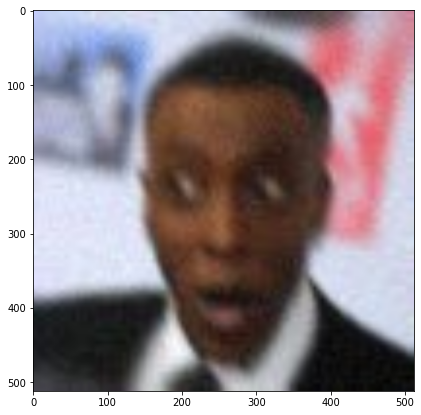

In [ ]:
plt.imshow(tensor2img(degraded_img[0])[:,:,::-1])

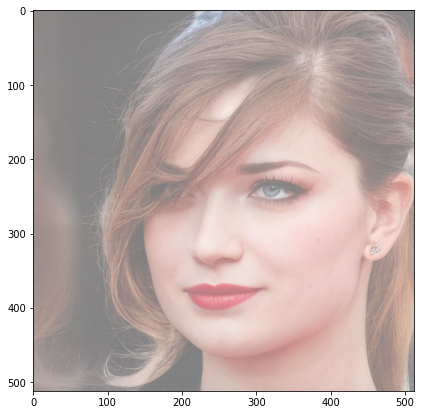

In [ ]:
plt.imshow(tensor2img(out_data[0])[:,:,::-1])

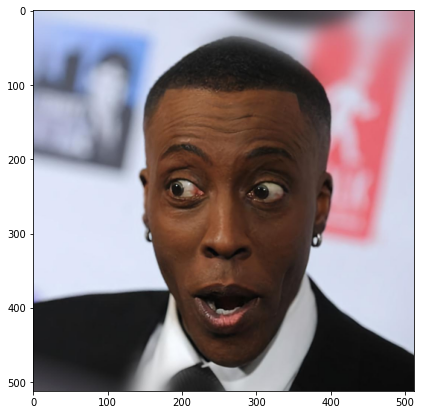

In [ ]:
plt.imshow(tensor2img(real_img[0])[:,:,::-1])